In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
#Load Dataset
train_path = r"/Users/astromeria/PycharmProjects/SPWLA_2021_Geolatinas/dataset/train_dataset_clean.csv"
train_data = pd.read_csv(train_path)
print(train_data)

discarded =  ["WELLNUM", "DEPTH"]
targets = ['PHIF', 'VSH', 'SW']
features = ["DTC","DEN","GR","NEU", "RDEP","RMED"]
train_data = train_data.drop(columns=discarded)
print(len(train_data))
train_data = train_data.dropna()
train_data = train_data.sample(n=1000,replace=False)
print(len(train_data))


#separate in x (inputs) and y(targets or outputs)
x_train = train_data.loc[:, ~train_data.columns.isin(targets)]
y_train = train_data.loc[:, targets]

print(x_train)
print(y_train)

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.15)

#Normalize data
sc = StandardScaler()
x_train = pd.DataFrame(sc.fit_transform(x_train))
x_test = pd.DataFrame(sc.transform(x_test))


       WELLNUM         DEPTH        DTC  DTS       DEN         GR       NEU  \
0            0  14121.660105   89.64610  NaN  2.577700   88.85730  0.277790   
1            0  14122.160105   96.01520  NaN  2.474800  120.89490  0.294806   
2            0  14122.660105  104.04570  NaN  2.333800  153.51950  0.447361   
3            0  14123.160105  113.50100  NaN  2.235800  182.85310  0.579637   
4            0  14123.660105  117.78170  NaN  2.227800  256.19600  0.556317   
...        ...           ...        ...  ...       ...        ...       ...   
42304        8  12142.500000   64.57612  NaN  2.613020   32.91600  0.109335   
42305        8  12143.000000   66.20669  NaN  2.614332   28.76523  0.099368   
42306        8  12143.500000   67.43187  NaN  2.620479   25.70403  0.097774   
42307        8  12144.000000   66.56465  NaN  2.623435   22.94222  0.089295   
42308        8  12144.500000   66.92158  NaN  2.617516   22.30438  0.091876   

           PEF      RDEP      RMED      PHIF   SW  

In [3]:
#training history plotting function
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Squared Error ')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,1])
  plt.legend()

 
  plt.show()

In [4]:
#model
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(x_train.keys())]),
    layers.Dropout(0.1),
   
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.1),
    
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.1),
   
    
    layers.Dense(len(y_train.keys()))
  ])
  optimizer = tf.keras.optimizers.Adam(0.001)
  model.compile(loss="mse",
                optimizer=optimizer,
                metrics=[ tf.keras.metrics.RootMeanSquaredError()])
  return model

#create a model instance
checkpoint_path = r"/Users/astromeria/Documents/SPWLA_competition/weights/22Jan.h5"
checkpoint = keras.callbacks.ModelCheckpoint( checkpoint_path, save_best_only=True, monitor = "val_loss")
model = build_model()

history = model.fit(
  x_train, y_train,
  epochs=150, validation_split = 0.1, verbose=2, callbacks = checkpoint)#just 10% for validation to use most of the data on training
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()
#plot_history(history)

Epoch 1/150


2022-01-22 17:52:03.841685: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-22 17:52:03.886716: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


24/24 - 1s - loss: 0.2539 - root_mean_squared_error: 0.5039 - val_loss: 0.0698 - val_root_mean_squared_error: 0.2642
Epoch 2/150
24/24 - 0s - loss: 0.0702 - root_mean_squared_error: 0.2650 - val_loss: 0.0320 - val_root_mean_squared_error: 0.1789
Epoch 3/150
24/24 - 0s - loss: 0.0411 - root_mean_squared_error: 0.2028 - val_loss: 0.0187 - val_root_mean_squared_error: 0.1367
Epoch 4/150
24/24 - 0s - loss: 0.0321 - root_mean_squared_error: 0.1793 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1085
Epoch 5/150
24/24 - 0s - loss: 0.0259 - root_mean_squared_error: 0.1609 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0945
Epoch 6/150
24/24 - 0s - loss: 0.0238 - root_mean_squared_error: 0.1543 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0934
Epoch 7/150
24/24 - 0s - loss: 0.0217 - root_mean_squared_error: 0.1472 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0815
Epoch 8/150
24/24 - 0s - loss: 0.0190 - root_mean_squared_error: 0.1379 - val_loss: 0.0060 - val_root_mean_sq

Epoch 65/150
24/24 - 0s - loss: 0.0051 - root_mean_squared_error: 0.0716 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0355
Epoch 66/150
24/24 - 0s - loss: 0.0048 - root_mean_squared_error: 0.0695 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0399
Epoch 67/150
24/24 - 0s - loss: 0.0044 - root_mean_squared_error: 0.0664 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0350
Epoch 68/150
24/24 - 0s - loss: 0.0043 - root_mean_squared_error: 0.0653 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0363
Epoch 69/150
24/24 - 0s - loss: 0.0045 - root_mean_squared_error: 0.0671 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0341
Epoch 70/150
24/24 - 0s - loss: 0.0045 - root_mean_squared_error: 0.0668 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0343
Epoch 71/150
24/24 - 0s - loss: 0.0044 - root_mean_squared_error: 0.0664 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0326
Epoch 72/150
24/24 - 0s - loss: 0.0046 - root_mean_squared_error: 0.0681 - val_loss: 0.001

24/24 - 0s - loss: 0.0027 - root_mean_squared_error: 0.0519 - val_loss: 8.5580e-04 - val_root_mean_squared_error: 0.0293
Epoch 128/150
24/24 - 0s - loss: 0.0028 - root_mean_squared_error: 0.0532 - val_loss: 9.0863e-04 - val_root_mean_squared_error: 0.0301
Epoch 129/150
24/24 - 0s - loss: 0.0028 - root_mean_squared_error: 0.0532 - val_loss: 7.2665e-04 - val_root_mean_squared_error: 0.0270
Epoch 130/150
24/24 - 0s - loss: 0.0030 - root_mean_squared_error: 0.0546 - val_loss: 7.9930e-04 - val_root_mean_squared_error: 0.0283
Epoch 131/150
24/24 - 0s - loss: 0.0025 - root_mean_squared_error: 0.0501 - val_loss: 8.8138e-04 - val_root_mean_squared_error: 0.0297
Epoch 132/150
24/24 - 0s - loss: 0.0029 - root_mean_squared_error: 0.0535 - val_loss: 8.0067e-04 - val_root_mean_squared_error: 0.0283
Epoch 133/150
24/24 - 0s - loss: 0.0026 - root_mean_squared_error: 0.0508 - val_loss: 8.6188e-04 - val_root_mean_squared_error: 0.0294
Epoch 134/150
24/24 - 0s - loss: 0.0028 - root_mean_squared_error: 0.

,loss,root_mean_squared_error,val_loss,val_root_mean_squared_error,epoch
145,0.002531,0.050308,0.000765,0.027655,145
146,0.002415,0.049148,0.000804,0.028355,146
147,0.002460,0.049603,0.000758,0.027532,147
148,0.002555,0.050549,0.000859,0.029316,148
149,0.002309,0.048056,0.000762,0.027605,149


5/5 - 0s - loss: 0.0011 - root_mean_squared_error: 0.0330
<bound method NDFrame.head of          PHIF     VSH      SW
33356  0.0430  0.6820  1.0000
5496   0.0200  0.3563  1.0000
17734  0.1510  0.0830  0.2370
8541   0.0922  0.3583  1.0000
33332  0.1140  0.8250  1.0000
...       ...     ...     ...
17862  0.1570  0.5350  0.8170
33853  0.1360  0.0300  0.4480
8406   0.1690  0.2886  0.7734
17934  0.2300  0.0300  0.1230
18119  0.2470  0.1810  0.2790

[150 rows x 3 columns]>


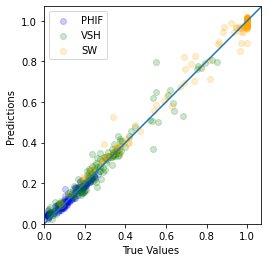

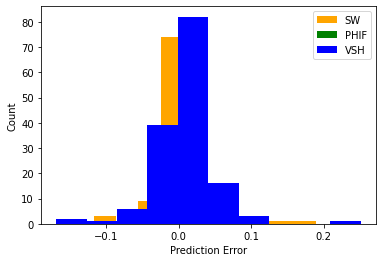

In [5]:
model.load_weights(checkpoint_path)

loss, mse = model.evaluate(x_test, y_test, verbose=2)
test_predictions = model.predict(x_test)
print(y_test.head)

col_names_y = [ "PHIF","VSH", "SW"]
plt.scatter(y_test["PHIF"], test_predictions[:,0], color = "blue", label = col_names_y[0], alpha=0.2)
plt.scatter(y_test["VSH"], test_predictions[:,1], color = "green", label = col_names_y[1], alpha=0.2)
plt.scatter(y_test["SW"], test_predictions[:,2], color = "orange", label = col_names_y[2],alpha=0.2)



           
plt.xlabel('True Values ')
plt.ylabel('Predictions ')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
plt.legend()
_ = plt.plot([-100, 100], [-100, 100])
plt.show()


error = test_predictions - np.asarray(y_test)
plt.hist(error[:,2] , color="orange", label = col_names_y[2])
plt.hist(error[:,0], color = "green", label = col_names_y[0])
plt.hist(error[:,1],  color="blue", label = col_names_y[1])

plt.legend()
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")